In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Q1: Dataset generation and noise
# Generate synthetic dataset
X, _ = make_blobs(
    n_samples=10000,
    centers=6,
    cluster_std=[0.5, 1.0, 1.5, 2.0, 0.8, 1.2],
    random_state=42
)

In [3]:
# Add random noise points
np.random.seed(42)
noise = np.random.uniform(low=-15, high=15, size=(200, X.shape[1]))
X = np.vstack([X, noise])

X.shape

(10200, 2)

In [7]:
# Q2: Feature engineering and scaling
# Derived features
euclidean_distances = np.sqrt(np.sum(X**2, axis=1)).reshape(-1, 1)
feature_product = (X[:, 0] * X[:, 1]).reshape(-1, 1)

X_engineered = np.hstack([X, euclidean_distances, feature_product])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_engineered)
X_scaled.shape

(10200, 4)

In [8]:
# Q3: Evaluating DBSCAN for each parameter pair
def evaluate_dbscan(X, eps_values, min_samples_values):
    results = []
    silhouette_heatmap = np.zeros((len(eps_values), len(min_samples_values)))
    ch_heatmap = np.zeros((len(eps_values), len(min_samples_values)))

    for i, eps in enumerate(eps_values):
        for j, min_samples in enumerate(min_samples_values):
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(X)

            if len(set(labels)) > 1:  # Avoid single-cluster cases
                sil_score = silhouette_score(X, labels)
                ch_score = calinski_harabasz_score(X, labels)

                silhouette_heatmap[i, j] = sil_score
                ch_heatmap[i, j] = ch_score

                results.append((eps, min_samples, sil_score, ch_score))
            else:
                silhouette_heatmap[i, j] = -1
                ch_heatmap[i, j] = -1

                results.append((eps, min_samples, -1, -1))

    return results, silhouette_heatmap, ch_heatmap

In [9]:
eps_values = np.arange(0.01, 0.2, 0.01)
min_samples_values = range(2, 16, 2)

results, silhouette_heatmap, ch_heatmap = evaluate_dbscan(
    X_scaled, eps_values, min_samples_values
)

len(results), silhouette_heatmap.shape, ch_heatmap.shape


(133, (19, 7), (19, 7))

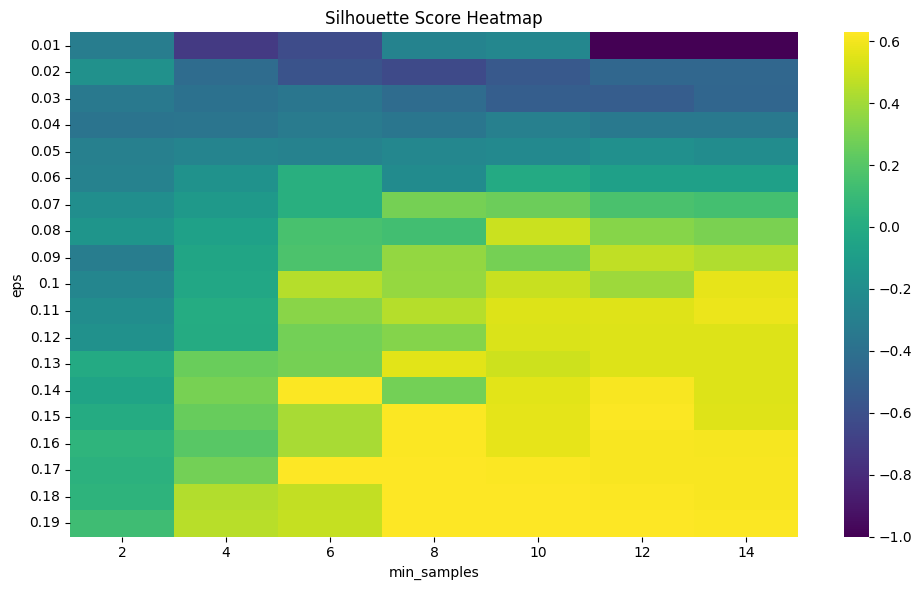

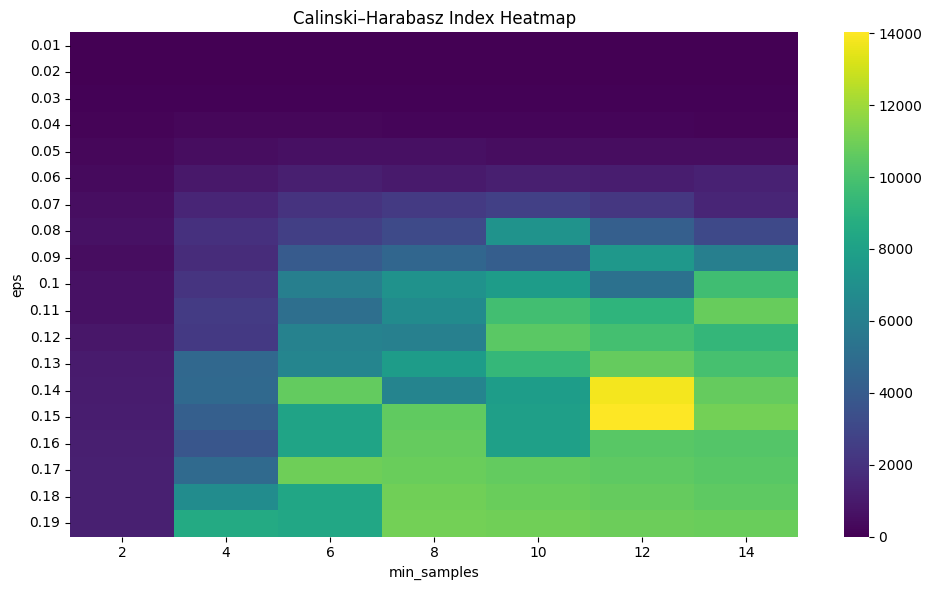

In [10]:
figsize = (10, 6)
cmap = "viridis"

eps_ticks = np.round(eps_values, 2)
min_samples_ticks = list(min_samples_values)

# Silhouette Score Heatmap
plt.figure(figsize=figsize)
sns.heatmap(
    silhouette_heatmap,
    xticklabels=min_samples_ticks,
    yticklabels=eps_ticks,
    annot=False,
    cmap=cmap
)
plt.title("Silhouette Score Heatmap")
plt.xlabel("min_samples")
plt.ylabel("eps")
plt.tight_layout()
plt.show()

# Calinski–Harabasz Index Heatmap
plt.figure(figsize=figsize)
sns.heatmap(
    ch_heatmap,
    xticklabels=min_samples_ticks,
    yticklabels=eps_ticks,
    annot=False,
    cmap=cmap
)
plt.title("Calinski–Harabasz Index Heatmap")
plt.xlabel("min_samples")
plt.ylabel("eps")
plt.tight_layout()
plt.show()


In [11]:
sil_mat = np.where(silhouette_heatmap == -1, np.nan, silhouette_heatmap)
ch_mat  = np.where(ch_heatmap == -1, np.nan, ch_heatmap)

best_sil_flat = np.nanargmax(sil_mat)
best_ch_flat  = np.nanargmax(ch_mat)

best_sil_eps_idx, best_sil_ms_idx = np.unravel_index(best_sil_flat, sil_mat.shape)
best_ch_eps_idx, best_ch_ms_idx   = np.unravel_index(best_ch_flat, ch_mat.shape)

In [12]:
best_sil_eps = eps_values[best_sil_eps_idx]
best_sil_ms  = list(min_samples_values)[best_sil_ms_idx]
best_sil_score = sil_mat[best_sil_eps_idx, best_sil_ms_idx]

best_ch_eps = eps_values[best_ch_eps_idx]
best_ch_ms  = list(min_samples_values)[best_ch_ms_idx]
best_ch_score = ch_mat[best_ch_eps_idx, best_ch_ms_idx]

print("Best Silhouette:", best_sil_eps, best_sil_ms, "score =", best_sil_score)
print("Best CH:", best_ch_eps, best_ch_ms, "score =", best_ch_score)

Best Silhouette: 0.19 8 score = 0.6285085730530584
Best CH: 0.15000000000000002 12 score = 14027.219488285737


In [13]:
# Q6: PCA-based visualization
def visualize_best_clustering(X_scaled, labels, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1],
                c=labels, cmap='viridis', s=5)
    plt.title(title)
    plt.colorbar(label="Cluster Label")
    plt.show()

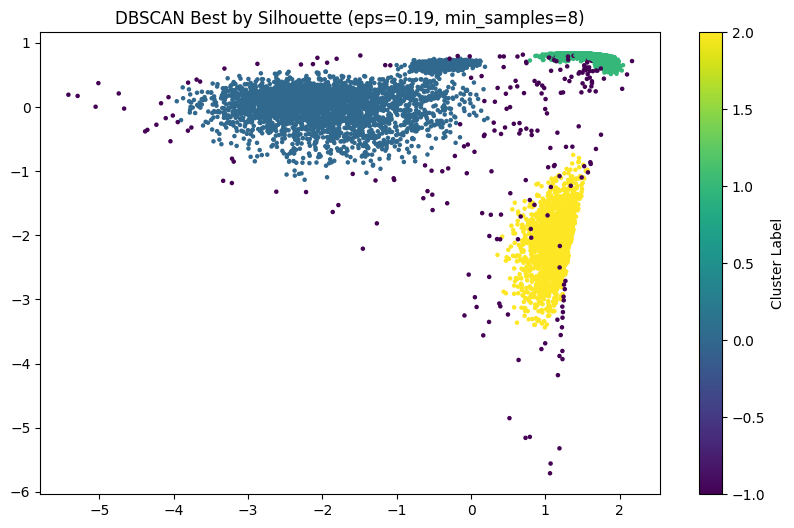

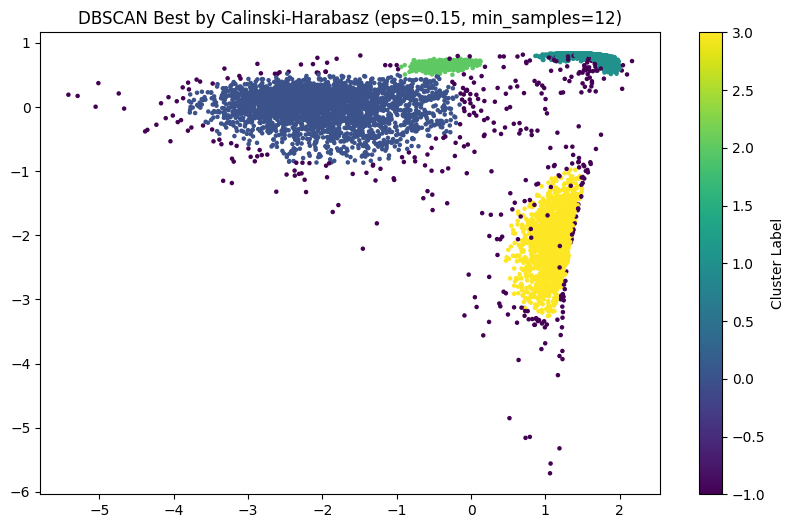

In [14]:
dbscan_sil = DBSCAN(eps=best_sil_eps, min_samples=best_sil_ms)
labels_sil = dbscan_sil.fit_predict(X_scaled)

dbscan_ch = DBSCAN(eps=best_ch_eps, min_samples=best_ch_ms)
labels_ch = dbscan_ch.fit_predict(X_scaled)

visualize_best_clustering(
    X_scaled, labels_sil,
    title=f"DBSCAN Best by Silhouette (eps={best_sil_eps:.2f}, min_samples={best_sil_ms})"
)

visualize_best_clustering(
    X_scaled, labels_ch,
    title=f"DBSCAN Best by Calinski-Harabasz (eps={best_ch_eps:.2f}, min_samples={best_ch_ms})"
)
